Please wait...


  0%|          | 0/100 [00:00<?, ?it/s]

Operation took 189.506 seconds
Converting pictures to .mp4...
Conversion completed


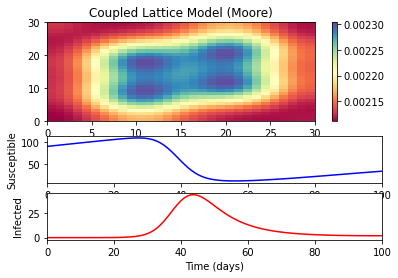

In [1]:
####################################################################
###    This is the PYTHON version of program 7.3 from page 256 of  #
### "Modeling Infectious Disease in humans and animals"            #
### by Keeling & Rohani.										   #
###																   #
### It is the SIR epidemic on an nxn lattice with coupling (rho)   #
### to the 8 nearest neighbours. nI defines the number of lattice  #
### sites (chosen randomly) that start with some infection.        #
####################################################################

###################################
### Written by Ilias Soumpasis    #
### ilias.soumpasis@ucd.ie (work) #
### ilias.soumpasis@gmail.com	  #
###################################

import scipy.integrate as spi
import numpy as np
import pylab as pl
import time
import cv2
import os
import matplotlib.cm as cm

# For the progress bar:
from time import sleep
from tqdm.notebook import tqdm

### Select if you want to make a video (faster way) 
video = 1
### or just in-time plotting
# video = 0
t = time.time()

n = 30
beta = 4 #0.42 # Transmission rate
gamma = 0.14 #0.14 # Recovery rate
mu = 0.001 #0.0001
rho = 0.5 #0.1 # Has to be < 1
X0 = 0.1
nI = 3 # Number of initial random sites
N = 1 # Multiplies some terms of rho
nu = mu
# timestep = 1
ND = MaxTime = 100  # 300
# C = np.arange(0.0, 1.0, 0.001)
X = X0*np.ones((n, n))
Y = np.zeros(n*n)
# ind = np.ceil(n*n * np.random.uniform(size=int(nI))).astype(int) # Initial random sites
ind = np.array([250,350,550,650])
for i in range(len(ind)):
    Y[ind[i]] = 0.001*X0

INPUT1 = np.hstack((X0 * np.ones((n * n)), Y))

Y3 = Y
Y = np.reshape(Y, (n, n))
Y2 = Y

INPUT3 = np.hstack((X, Y))

INPUT2 = np.reshape(INPUT3, (2 * n * n, 1))

for i in range(len(INPUT1)):
    INPUT1[i] = INPUT2[i]

INPUT = INPUT1
ndem = np.zeros((n, n))
Size = n
### Note the size loop
for i in range(Size):
    for j in range(Size):
        # ndem[i][j]=(1-8*rho)*N
        ndem[i][j] = (1 - 4*rho)*N

        if i >          0: ndem[i][j] += rho * N
        if i < (Size - 1): ndem[i][j] += rho * N
        if j >          0: ndem[i][j] += rho * N
        if j < (Size - 1): ndem[i][j] += rho * N

        # Extra
        if i >          0 and j >          0: ndem[i][j] += rho * N
        if i < (Size - 1) and j < (Size - 1): ndem[i][j] += rho * N
        if i >          0 and j < (Size - 1): ndem[i][j] += rho * N
        if i < (Size - 1) and j >          0: ndem[i][j] += rho * N


def diff_eqs(INP, t):
    V = INP
    Y = np.zeros(2 * n * n)

    # internal dynamics
    for i in range(Size):
        for j in range(Size):
            ss = i + j * Size * 2
            ii = Size + i + j * Size * 2
            Y[ss] = nu - beta*(1 - 4*rho)*V[ss]*V[ii] / ndem[i][j] - mu*V[ss] #1-8*rho
            Y[ii] = beta*(1 - 4*rho)*V[ss]*V[ii] / ndem[i][j] - (gamma + mu)*V[ii] #1-8*rho

            # Interactions with four neighbours - Moore neighborhood
            if i > 0:
                FoI = beta * V[ss] * rho * V[ii - 1] / ndem[i][j]
                Y[ss] -= FoI
                Y[ii] += FoI
            if i < (Size - 1):
                FoI = beta * V[ss] * rho * V[ii + 1] / ndem[i][j]
                Y[ss] -= FoI
                Y[ii] += FoI
            if j > 0:
                FoI = beta * V[ss] * rho * V[ii - Size * 2] / ndem[i][j]
                Y[ss] -= FoI
                Y[ii] += FoI
            if j < (Size - 1):
                FoI = beta * V[ss] * rho * V[ii + Size * 2] / ndem[i][j]
                Y[ss] -= FoI
                Y[ii] += FoI

            # Extra
            if i > 0 and j > 0:
                FoI = beta * V[ss] * rho * V[ii - 1 - Size * 2] / ndem[i][j]
                Y[ss] -= FoI
                Y[ii] += FoI
            if i < (Size - 1) and j < (Size - 1):
                FoI = beta * V[ss] * rho * V[ii + 1 + Size * 2] / ndem[i][j]
                Y[ss] -= FoI
                Y[ii] += FoI
            if i < (Size - 1) and j > 0:
                FoI = beta * V[ss] * rho * V[ii + 1 - Size * 2] / ndem[i][j]
                Y[ss] -= FoI
                Y[ii] += FoI
            if i > 0 and j < (Size - 1):
                FoI = beta * V[ss] * rho * V[ii - 1 + Size * 2] / ndem[i][j]
                Y[ss] -= FoI
                Y[ii] += FoI

    return Y


ola = np.zeros((n*n), dtype=int)
for i in range(Size):
    for j in range(Size):
        ola[i*n + j] = i*Size*2 + j

ola1 = ola + n
tcS = [X0*n*n]
tcI = [sum(Y3[range(n*n)])]
tc22 = np.zeros((n,n))
if video == 1:
    if os.path.exists('movie') == True:
        pass
    else:
        os.mkdir('movie')

    print('Please wait...')
    for k in tqdm(range(ND)): #tqdm is the progress bar
        t_range = np.arange(2.0)
        RES = spi.odeint(diff_eqs, INPUT, t_range)
        INPUT = RES[-1]

        tcS.append(sum(RES[-1][ola]))
        tcI.append(sum(RES[-1][ola1]))

        if k % 1 == 0:
            pl.clf()
            tc22 = np.reshape(RES[-1][ola1], (n, n))
            pl.subplot(211)
            # pl.axis('equal')
            pl.pcolor(tc22, cmap=cm.get_cmap("Spectral"))
            pl.title('Coupled Lattice Model (Moore)')
            pl.colorbar()

            pl.subplot(413)
            pl.plot(tcS, color='b')
            pl.ylabel('Susceptible')
#             pl.ylim(60,80)
            pl.xlim(0,MaxTime)

            pl.subplot(414)
            pl.plot(tcI, color='r')
#             pl.ylim(0,0.001)
#             pl.yticks([0,0.001])
            pl.ylabel('Infected')
            pl.xlabel('Time (days)')
            pl.xlim(0,MaxTime)
            
            pl.savefig("movie/frame_%04d.png" % k)
            # watch the progress 
            #  print(k)

    # You will mencoder from mplayer for this to work
    # With windows you have to modify the path
    # With linux if you have mencoder istalled usually it should work
    # Format is windows media player - plays on windows
    # You could try other formats also
    
    # Select different video speed
    # os.system('mencoder "mf://movie/*.png" -mf fps=5:type=png -ovc lavc -lavcopts vcodec=wmv1 -of avi -o movie/movie_very_slow.avi')
    # os.system('mencoder "mf://movie/*.png" -mf fps=10:type=png -ovc lavc -lavcopts vcodec=wmv1 -of avi -o movie/movie_slow.avi')
    # os.system('mencoder "mf://movie/*.png" -mf fps=25:type=png -ovc lavc -lavcopts vcodec=wmv1 -of avi -o movie/movie_fast.avi')

    print("Operation took %g seconds" % (time.time() - t))
    print('Converting pictures to .mp4...')
    image_folder = 'movie'
    video_name = 'video.mp4'

    images = [img for img in os.listdir(image_folder)[:MaxTime] if img.endswith(".png")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    frame_rate = 25
    video = cv2.VideoWriter(video_name, 0, frame_rate, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()

    print('Conversion completed')
    # Delete images to save work space
    os.system('rm movie/*.png')

else:
    ## You could also try plotting at each step but it is slow
    pl.ion()
    for k in range(ND):
        t_range = np.arange(2.0)
        RES = spi.odeint(diff_eqs, INPUT, t_range)
        INPUT = RES[-1]

        tcS.append(sum(RES[-1][ola]))
        tcI.append(sum(RES[-1][ola1]))

        if k % 100 == 0:
            print(k)

        # Changing the k%50 parameter you change the frames you are watching
        #  With 1 you can see all the graphs
        """
        if k%10==0:
            pl.clf()
            tc22=np.reshape(RES[-1][ola1], (n,n))
            pl.subplot(211)
            pl.pcolor(tc22, cmap=pl.cm.spectral)
            pl.title('Coupled Lattice Model')
            pl.colorbar()
            pl.subplot(413)
            pl.plot(tcS, color='b')
            pl.ylabel('Susceptible')
            pl.subplot(414)
            pl.plot(tcI, color='r')
            pl.ylabel('Infected')
            pl.xlabel('Time (days)')
            ### watch the progress
            print k
            #pl.draw()
            """

    pl.clf()
    tc22 = np.reshape(RES[-1][ola1], (n, n))
    pl.figure(figsize=(6,10))
    pl.subplot(211)
    pl.pcolor(tc22, cmap=cm.get_cmap("Spectral"))
    pl.title('Coupled Lattice Model (Moore)')
    pl.colorbar()

    pl.figure(figsize=(6,8))
    pl.subplot(413)
    pl.plot(tcS, color='b')
    pl.ylabel('Susceptible')
    pl.ylim(60,80)
    pl.xlim(0,MaxTime)

    pl.subplot(414)
    pl.plot(tcI, color='r')
    pl.ylabel('Infected')
    pl.xlabel('Time (days)')
    pl.ylim(0,0.001)
    pl.yticks([0,0.001])
    pl.xlim(0,MaxTime)

    pl.draw()
    pl.ioff()
    pl.show()